In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sns.set(style="white")

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

## Dataset

### Mobility

In [2]:
mobility_data = pd.read_csv(
    "../Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"]
)

/Users/N547113/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & (mobility_data["sub_region_1"].isnull())
]
mobility_data_us = mobility_data_us.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
mobility_data_us.iloc[:,1:] = mobility_data_us.iloc[:,1:].apply(lambda x: x/100 + 1)

In [4]:
mobility_data_us = pd.DataFrame({
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

### Cases

In [5]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "../Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"]
)
ms_us_covid = ms_covid[(ms_covid["Country_Region"]=="United States") & (ms_covid["AdminRegion1"].isnull())]
ms_us_covid = ms_us_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.reset_index(drop=True, inplace=True)

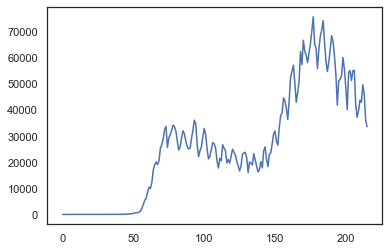

In [6]:
# Create the 3 categories S, I, R for US data (UK does not include R)
ms_us_covid.fillna(0, inplace=True)
ms_us_covid["I"] = ms_us_covid["Confirmed"] - ms_us_covid["Deaths"] - ms_us_covid["Recovered"]

ms_us_covid["S"] = 70000000 - ms_us_covid["I"]

ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear
ms_us_covid = ms_us_covid[:-1].copy()

plt.plot(ms_us_covid["ConfirmedChange"])

### Merge

In [7]:
final_data = ms_us_covid.set_index("Updated").merge(
    mobility_data_us.set_index("date"), how='left', left_index=True, right_index=True
).reset_index()
final_data.dropna(inplace=True)

## Model

In [8]:
class COVIDGPModel(object):
    
    def __init__(
        self, 
        name,
        likelihood=gpflow.likelihoods.Gaussian(),
        kernel=gpflow.kernels.Matern32(),
        inducing_variable_func=None,
        variational_optimizer=None,
        model_variables_optimizer=None,
        n_iter=1000,
    ):
        self.name = name
        self.likelihood = likelihood
        self.kernel = kernel
        self.inducing_variable_func = inducing_variable_func or self._inducing_variable_func
        self.variational_optimizer = variational_optimizer or NaturalGradient(gamma=1.0)
        self.model_variables_optimizer = model_variables_optimizer or tf.optimizers.Adam(0.01)
        self.n_iter = n_iter
        
        self._model = None
        self._x_scaler = None
        self._y_scaler = None
        self._elbo = []
        
    def _inducing_variable_func(self, data):
        size = int(data.shape[0] * 0.1)
        
        Z = data[
            np.random.randint(data.shape[0], size=size), 0
        ]

        if data.shape[1] <= 1:
            return Z.reshape((-1, 1))
        
        for col in range(1, data.shape[1]):
            Z = np.vstack([
                Z, data[
                    np.random.randint(data.shape[0], size=size), col
                ]
            ])
            
        return Z.T
           
    def _init_model(self, X):
        self._model = gpflow.models.SVGP(
            likelihood=self.likelihood,
            kernel=self.kernel,
            inducing_variable=self.inducing_variable_func(X), 
            num_data=X.shape[0]
        )

        set_trainable(self._model.q_mu, False)
        set_trainable(self._model.q_sqrt, False)
        
        return self._model
        
    def _loss_function(self, X, y):
        model = self._model
        def _loss():
            return model.training_loss((X, y))
        return _loss
        
    def train(self, X, y):
        self._init_model(X)

        for _ in range(ci_niter(self.n_iter)):
            self.model_variables_optimizer.minimize(
                self._loss_function(X, y),
                self._model.trainable_variables
            )
            self.variational_optimizer.minimize(
                self._loss_function(X, y),
                [(self._model.q_mu, self._model.q_sqrt)]
            )
            self._elbo.append(self._model.elbo((X, y)))

    def predict(self, X):
        return self._model.predict_f(X)
    
    def plot_elbo(self, ax=None):
        if not self._model:
            raise RuntimeError('The model must be trained first')
            
        if not ax:
            ax = plt
        ax.plot(self._elbo)
        
    def plot_prediction(self, t, X, y, t_test=None, y_test=None, num_samples=20, ax=None):
        if not ax:
            _fig, ax = plt.subplots(1, figsize=(15, 4))
        
        Ypred = self._model.predict_f_samples(X, full_cov=True, num_samples=num_samples)
        mean, var = self._model.predict_f(X)

        ax.plot(t, np.squeeze(Ypred).T, "C1", alpha=0.2)
        ax.plot(t, mean, "-", c="C0")

        lo = (mean - 2 * tf.sqrt(var)).numpy()
        hi = (mean + 2 * tf.sqrt(var)).numpy()
        ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
        ax.plot(t, y, "o", c="C2", alpha=0.7, label="train")
        if (t_test is not None) and (y_test is not None):
            ax.plot(t_test, y_test, "o", c="C3", alpha=0.7, label="test")
            ax.legend()

In [9]:
def experiment(name, t, X, y, model_params=None, plot=False):
    np.random.seed(123)
    
    y_scaler = preprocessing.StandardScaler().fit(y)
    y = y_scaler.transform(y)

    x_scaler = preprocessing.StandardScaler().fit(X)
    X = x_scaler.transform(X)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    t_train, t_test = t[:-21,:], t[-21:,:]
    X_train, X_test = X[:-21,:], X[-21:,:]
    y_train, y_test = y[:-21,:], y[-21:,:]
    
    res = {}

    model = COVIDGPModel(name, **(model_params or {}))
    model.train(X_train, y_train)

    y_train_pred = y_scaler.inverse_transform(model.predict(X_train)[0].numpy())
    y_train_true = y_scaler.inverse_transform(y_train)

    y_test_pred = y_scaler.inverse_transform(model.predict(X_test)[0].numpy())
    y_test_true = y_scaler.inverse_transform(y_test)
    
    results = {
        'model': model.name,
        'likelihood': model.likelihood.__class__.__name__,
        'kernel': model.kernel.__class__.__name__,
        'within_sample': round(np.mean(y_train_true - y_train_pred), 0),
        'out_sample': round(np.mean(y_test_true - y_test_pred), 0)
    }

    if plot:
        f = plt.figure(figsize=(20,4))
        ax = f.add_subplot(1, 3, (1, 2))
        model.plot_prediction(t, X, y, t_test, y_test, ax=ax)
        ax = f.add_subplot(1, 3, 3)
        model.plot_prediction(t_test, X_test, y_test, t_test, y_test, ax=ax)
        
    return results, model

## Experiments

In [10]:
results = []

### $\lambda (t) = f(t)$

/Users/N547113/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


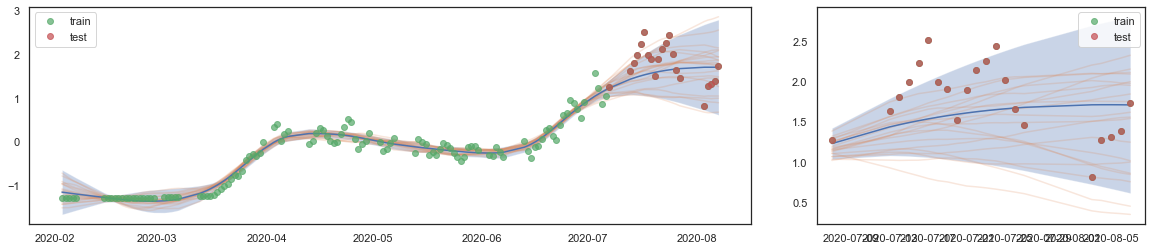

In [11]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = final_data[["index"]].to_numpy()

res, model = experiment('$f(t)$', t, X, y, plot=True)
results.append(res)

In [12]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.274866090409342
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.5468567829948014
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.028886340458810333
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 1)",float64,[[1.11503779...
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[0.96646945...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[5.91713462e-02, 0.00000000e+00, 0.00000000e+00..."


### $\lambda (t) = f(S(t), I(t))$

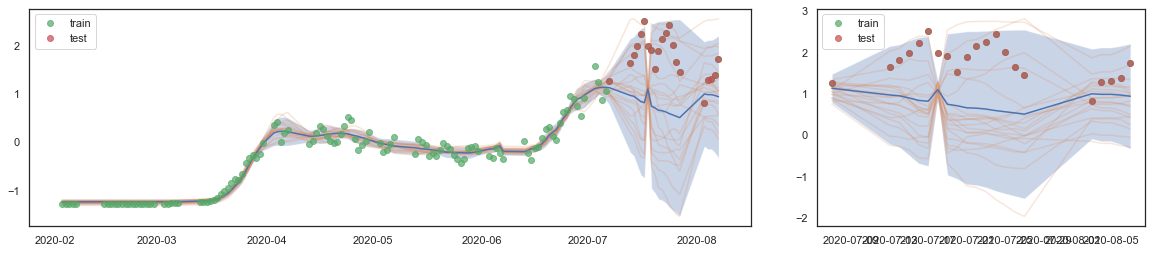

In [13]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = final_data[["S", "I"]].to_numpy()

res, model = experiment('$f(S(t), I(t))$', t, X, y, plot=True)
results.append(res)

In [14]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.3253411178065455
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.4743221012605394
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.02267309803735361
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 2)",float64,"[[-0.68713906, 0.68710368..."
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[5.50382626e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[4.44145669e-02, 0.00000000e+00, 0.00000000e+00..."


### $\lambda (t) = f(S(t)*I(t))$

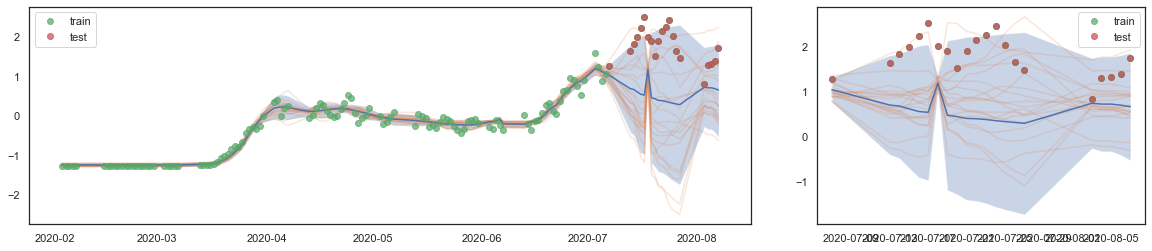

In [15]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = (
    final_data["S"] * final_data["I"]
).to_numpy().reshape(-1, 1)

res, model = experiment('$f(S(t)*I(t))$', t, X, y, plot=True)
results.append(res)

In [16]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.3537122261726362
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0081121128395762
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.021275705011229235
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 1)",float64,[[1.11159285...
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[0.9573958...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[7.18821947e-02, 0.00000000e+00, 0.00000000e+00..."


### $\lambda (t) = f(t, S(t)*I(t))$

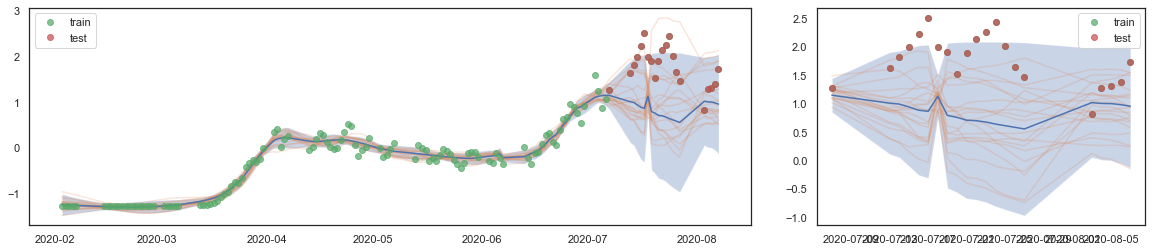

In [17]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    final_data[["index"]].to_numpy(),
    (final_data["S"] * final_data["I"]).to_numpy().reshape(-1, 1)
])

model_params = {
    'kernel': gpflow.kernels.Matern32(lengthscales=np.ones(X.shape[1]))
}

res, model = experiment('$f(t, S(t)*I(t))$', t, X, y, model_params=model_params, plot=True)
results.append(res)

In [18]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.7496536953105187
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[2.16144816 1.05420194]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.022861774544819538
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 2)",float64,"[[0.96752125, 0.69262997..."
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[0.7223603...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[5.84590498e-02, 0.00000000e+00, 0.00000000e+00..."


### $\lambda (t) = f(t, S(t), I(t))$

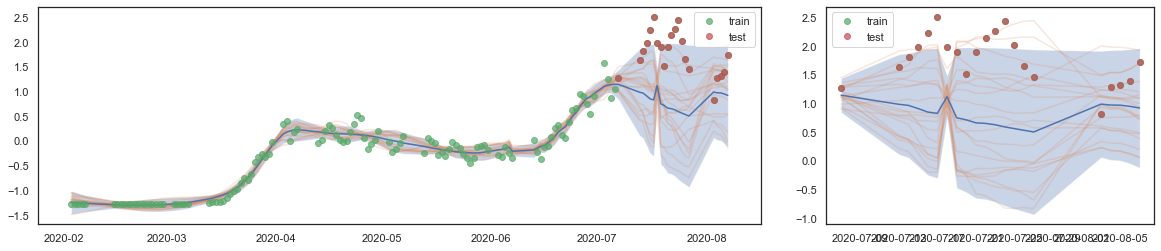

In [19]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    final_data[["index"]].to_numpy(),
    final_data[["S"]].to_numpy(),
    final_data[["I"]].to_numpy(),
])

model_params = {
    'kernel': gpflow.kernels.Matern32(lengthscales=np.ones(X.shape[1]))
}

res, model = experiment('$f(t, S(t), I(t))$', t, X, y, model_params=model_params, plot=True)
results.append(res)

In [20]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.6360700986244514
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[2.07208206 1.45761044 1.42374366]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.025608826411112545
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 3)",float64,"[[0.65622832, -0.88982417, -0.67563235..."
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[2.00979491e-03...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[7.83718484e-01, 0.00000000e+00, 0.00000000e+00..."


### $\lambda (t) = f(t, I(t), Home(t))$

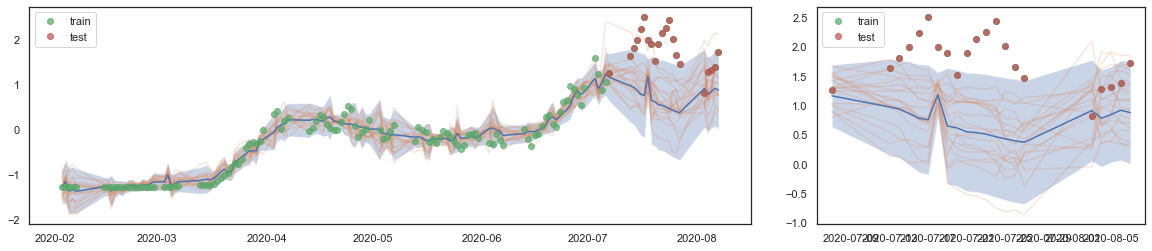

In [21]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    final_data[["index"]].to_numpy(),
    final_data[["I"]].to_numpy(),
    final_data[["HOME"]].to_numpy(),
])

model_params = {
    'kernel': gpflow.kernels.Matern32(lengthscales=np.ones(X.shape[1]))
}

res, model = experiment('$f(t, I(t), Home(t))$', t, X, y, model_params=model_params, plot=True)
results.append(res)

In [22]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.29348246164669806
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1.82457156 0.75843643 2.70945983]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.05605026761335109
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 3)",float64,"[[1.1374938, 1.03863774, 1.15279456..."
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[1.81104071...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[2.64926087e-01, 0.00000000e+00, 0.00000000e+00..."


### $\lambda (t) = f(t, S(t)*I(t), Home(t))$

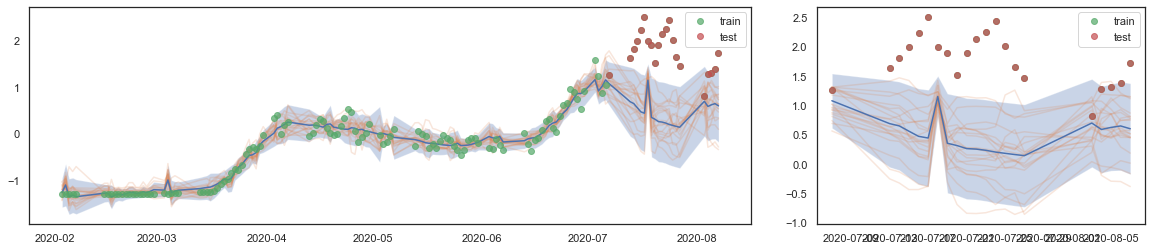

In [23]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    final_data[["index"]].to_numpy(),
    (final_data["S"] * final_data["I"]).to_numpy().reshape(-1, 1),
    final_data[["HOME"]].to_numpy(),
])

model_params = {
    'kernel': gpflow.kernels.Matern32(lengthscales=np.ones(X.shape[1]))
}

res, model = experiment('$f(t, S(t)*I(t), Home(t))$', t, X, y, model_params=model_params, plot=True)
results.append(res)

In [24]:
model._model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.193279266663281
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1.94558023 0.52752877 3.24787081]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.04590015076754754
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(11, 3)",float64,"[[1.12208555, 1.06160211, 1.39019326..."
SVGP.q_mu,Parameter,Identity,,False,"(11, 1)",float64,[[2.1620823...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[3.10869760e-01, 0.00000000e+00, 0.00000000e+00..."
